In [1]:
%%capture
!git init
!git pull https://github.com/Leofierus/eeg-alzheimers-detection.git

In [2]:
%%capture
!pip install mne
!pip install torchviz

In [3]:
!pip install pyprep

In [4]:
!pip install optuna

In [5]:
!pip install eeglabio
!conda install -c conda-forge eeglabio

Channels:
 - conda-forge
 - defaults
Platform: osx-arm64
Solving environment: done

## Package Plan ##

  environment location: /Users/yousef_aljazzazi/miniconda3

  added / updated specs:
    - eeglabio


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-25.3.1               |  py312h81bd7bf_1         1.1 MB  conda-forge
    eeglabio-0.0.3             |     pyhd8ed1ab_1          14 KB  conda-forge
    openssl-3.5.0              |       h81ee809_0         2.9 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         4.0 MB

The following NEW packages will be INSTALLED:

  eeglabio           conda-forge/noarch::eeglabio-0.0.3-pyhd8ed1ab_1 

The following packages will be UPDATED:

  conda                              25.1.1-py312h81bd7bf_1 --> 25.3.1-py312h81bd7bf_1 
  openssl                             

In [1]:
import mne
import os
import warnings
import json
import torch
import torchviz
import numpy as np
import pandas as pd
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from torchviz import make_dot
from sklearn.preprocessing import normalize
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import roc_curve, roc_auc_score

# Ignore RuntimeWarning
warnings.filterwarnings('ignore', category=RuntimeWarning)

In [2]:
data_dir = 'model-data'
train_dir = os.path.join(data_dir, 'train')
participants_file = os.path.join(data_dir, 'participants.tsv')


full_path = os.path.join(train_dir, "sub-001_eeg_chunk_4.set")
if not os.path.exists(full_path):
        print(f"⚠️ File sub-001_eeg_chunk_4.set not found in '{train_dir}'! Skipping...")





raw = mne.io.read_raw_eeglab(full_path, preload=False)

raw_2 = raw.copy()
# # Plot EEG signals
# # raw.plot(n_channels=19)

data = raw_2.get_data()  # Shape: (n_channels, n_samples)
sfreq = raw_2.info['sfreq']  # Sampling frequency
ch_names = raw_2.info['ch_names']  # Channel names
print(ch_names)
print(data.shape[1])
print(sfreq)

# print(raw)
# print(raw.info)

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
1425
95.0


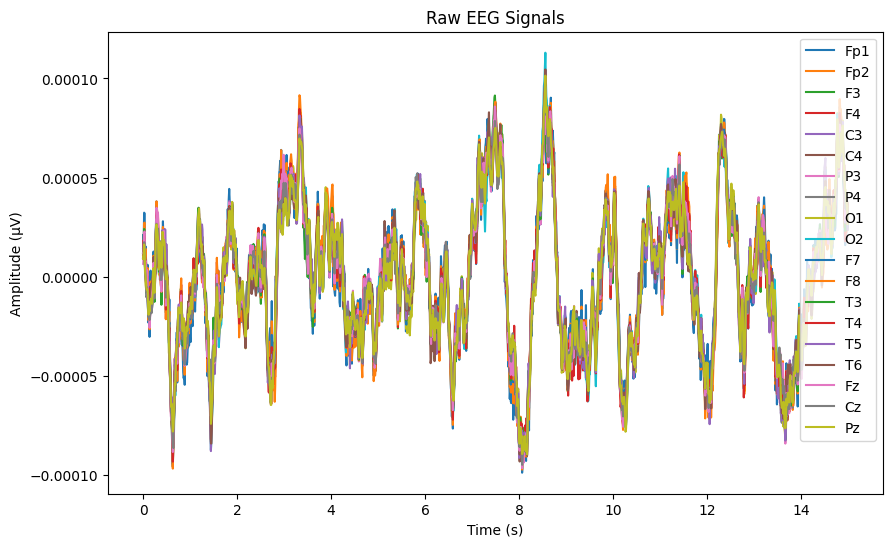

In [3]:
import matplotlib.pyplot as plt
import numpy as np

time = np.arange(data.shape[1]) / sfreq  # Time axis in seconds
plt.figure(figsize=(10, 6))
for i, ch in enumerate(ch_names):
    plt.plot(time, data[i] , label=ch)  # Offset channels for better visibility
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (µV)")
plt.title("Raw EEG Signals")
plt.legend(loc="upper right")
plt.show()


Using matplotlib as 2D backend.


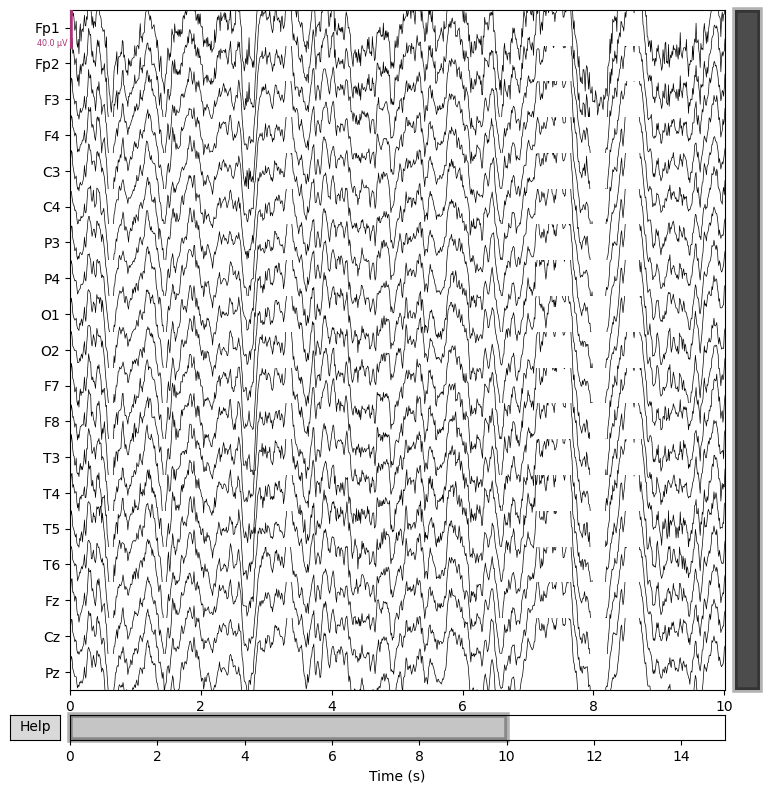

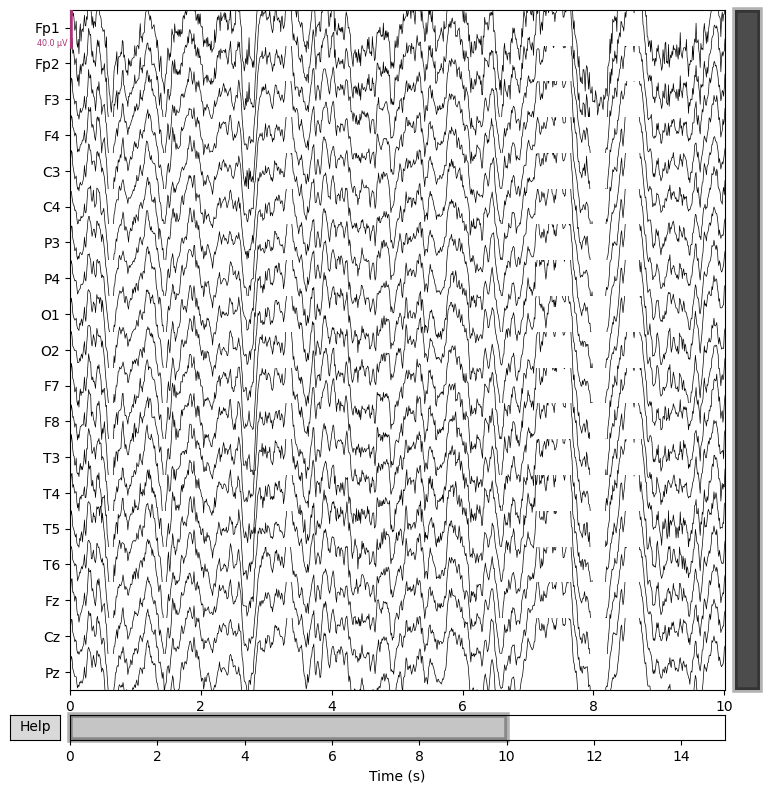

In [4]:
# raw.info.plot_sensors()
raw.plot()

Effective window size : 15.000 (s)


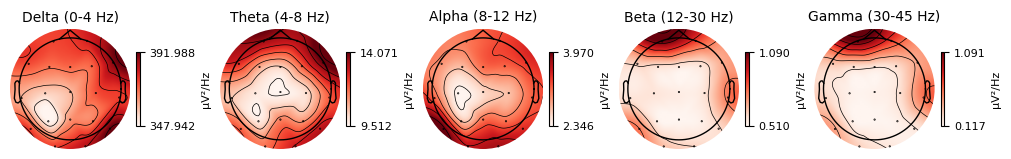

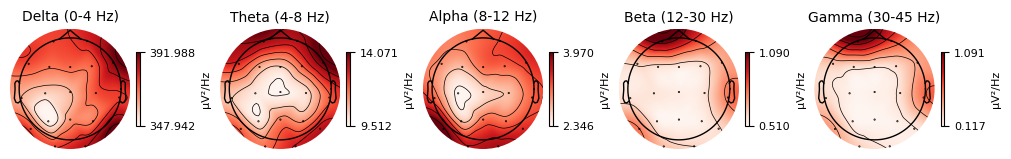

In [5]:
spectrum = raw.compute_psd()
spectrum.plot_topomap()

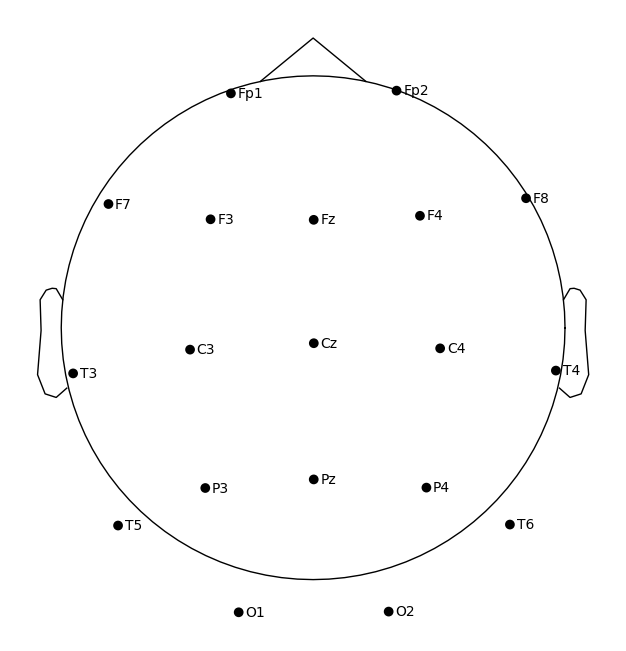

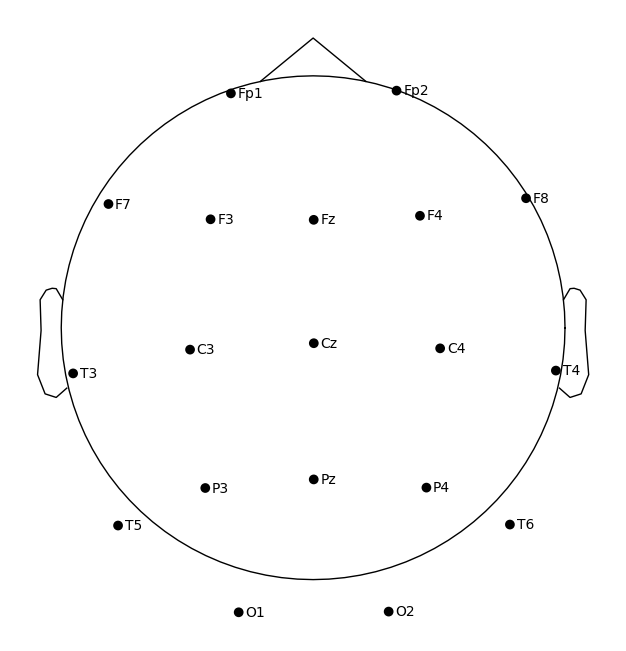

In [6]:
raw_2.info.plot_sensors(show_names=True)


In [7]:
events, _ = mne.events_from_annotations(raw)
raw.load_data()


<RawEEGLAB | sub-001_eeg_chunk_4.set, 19 x 1425 (15.0 s), ~238 KiB, data loaded>

In [8]:

# # 1. Apply a high-pass filter to remove slow drifts
# raw.filter(l_freq=1., h_freq=None)

# # 2. (Optional) Re-reference to common average
# raw.set_eeg_reference('average')

# # 3. (Optional) ICA for artifact removal (maybe not needed for 15s of resting-state)
# # Only if you expect blinks or muscle noise
# ica = mne.preprocessing.ICA(n_components=15, random_state=42)
# ica.fit(raw)
# ica.plot_components()

# # 4. Create fixed-length epochs (e.g., 2s with 50% overlap)
# epochs = mne.make_fixed_length_epochs(raw, duration=2.0, overlap=1.0, preload=True)

# # 5. Extract features or PSD
# psds, freqs = epochs.compute_psd(method='welch', fmin=1, fmax=45).get_data(return_freqs=True)


#Preprocessing

##Concatenation

In [9]:
import os
import re
from collections import defaultdict


def load_and_organize_chunks(base_dir):
    # Use defaultdict to gather chunk paths per subject
    subject_chunks = defaultdict(list)
    missing_chunks_report = {}

    # Scan both 'train' and 'test' directories
    for subfolder in ['train', 'test']:
        folder_path = os.path.join(base_dir, subfolder)
        for filename in os.listdir(folder_path):
            if filename.endswith('.set'):
                match = re.match(r"(sub-\d+)_eeg_chunk_(\d+)\.set", filename)
                if match:
                    subject_id = match.group(1)
                    chunk_number = int(match.group(2))
                    full_path = os.path.join(folder_path, filename)
                    subject_chunks[subject_id].append((chunk_number, full_path))

    raw_data_by_subject = {}

    for subject_id, chunks in subject_chunks.items():
        # Sort chunks by their number
        sorted_chunks = sorted(chunks, key=lambda x: x[0])

        # Check for missing chunks
        chunk_numbers = [c[0] for c in sorted_chunks]
        expected = list(range(chunk_numbers[0], chunk_numbers[-1] + 1))
        missing = sorted(set(expected) - set(chunk_numbers))
        if missing:
            missing_chunks_report[subject_id] = missing
            print(f"[!] Missing chunks for {subject_id}: {missing}")

        # Load and concatenate the chunks
        raws = []
        for chunk_num, filepath in sorted_chunks:
            # print(f"Loading {filepath}")
            raw = mne.io.read_raw_eeglab(filepath, preload=True)
            raws.append(raw)

        combined_raw = mne.concatenate_raws(raws)
        raw_data_by_subject[subject_id] = combined_raw

    return raw_data_by_subject, missing_chunks_report


In [10]:
data_dir = 'model-data'
raws_by_subject, missing = load_and_organize_chunks(data_dir)

print("\nLoaded subjects:")
print(list(raws_by_subject.keys()))

if missing:
    print("\nMissing chunk report:")
    for subj, chunks in missing.items():
        print(f"{subj}: Missing chunks {chunks}")



Loaded subjects:
['sub-036', 'sub-018', 'sub-055', 'sub-008', 'sub-045', 'sub-026', 'sub-029', 'sub-017', 'sub-074', 'sub-058', 'sub-007', 'sub-039', 'sub-044', 'sub-054', 'sub-065', 'sub-041', 'sub-019', 'sub-034', 'sub-086', 'sub-048', 'sub-069', 'sub-047', 'sub-057', 'sub-079', 'sub-080', 'sub-071', 'sub-081', 'sub-005', 'sub-066', 'sub-025', 'sub-004', 'sub-059', 'sub-035', 'sub-020', 'sub-068', 'sub-014', 'sub-027', 'sub-084', 'sub-051', 'sub-032', 'sub-013', 'sub-087', 'sub-050', 'sub-040', 'sub-006', 'sub-088', 'sub-043', 'sub-031', 'sub-011', 'sub-062', 'sub-028', 'sub-010', 'sub-067', 'sub-042', 'sub-012', 'sub-023', 'sub-078', 'sub-016', 'sub-009', 'sub-073', 'sub-037', 'sub-033', 'sub-056', 'sub-049', 'sub-046', 'sub-001', 'sub-063', 'sub-077', 'sub-070', 'sub-085', 'sub-082', 'sub-064', 'sub-083', 'sub-075', 'sub-024', 'sub-076', 'sub-015', 'sub-052', 'sub-003', 'sub-022', 'sub-002', 'sub-061', 'sub-053', 'sub-072', 'sub-021', 'sub-060', 'sub-038', 'sub-030']


###Saving the Data

In [ ]:
# #saving raw data
# output_path= "combined-raw"
# output_dir = os.path.join(data_dir,output_path)
# os.makedirs(output_dir, exist_ok=True)
# for subject_id in raws_by_subject.keys():
#   save_path = os.path.join(output_dir, f"{subject_id}_combined_raw.fif")
#   raws_by_subject.get(subject_id).save(save_path, overwrite=True)


Overwriting existing file.
Writing /content/model-data/combined-raw/sub-010_combined_raw.fif
Closing /content/model-data/combined-raw/sub-010_combined_raw.fif
[done]
Overwriting existing file.
Writing /content/model-data/combined-raw/sub-070_combined_raw.fif
Closing /content/model-data/combined-raw/sub-070_combined_raw.fif
[done]
Overwriting existing file.
Writing /content/model-data/combined-raw/sub-028_combined_raw.fif
Closing /content/model-data/combined-raw/sub-028_combined_raw.fif
[done]
Overwriting existing file.
Writing /content/model-data/combined-raw/sub-023_combined_raw.fif
Closing /content/model-data/combined-raw/sub-023_combined_raw.fif
[done]
Overwriting existing file.
Writing /content/model-data/combined-raw/sub-034_combined_raw.fif
Closing /content/model-data/combined-raw/sub-034_combined_raw.fif
[done]
Overwriting existing file.
Writing /content/model-data/combined-raw/sub-073_combined_raw.fif
Closing /content/model-data/combined-raw/sub-073_combined_raw.fif
[done]
Over

In [ ]:
# !zip -r /content/model-data/combined.zip /content/model-data/combined-raw

In [ ]:
# from google.colab import files
# files.download("/content/model-data/combined.zip")

#Filtering

In [ ]:
import mne

# Parameters
n_components = 15

# Stores cleaned data (raw + ICA object)
ica_by_subject = {}

for subject_id, raw in raws_by_subject.items():
    print(f"Processing {subject_id}...")

    # Filter raw data
    raw_filtered = raw.copy().filter(l_freq=None, h_freq=1.0)

    # Run ICA
    ica = mne.preprocessing.ICA(n_components=n_components, random_state=42, max_iter='auto')
    ica.fit(raw_filtered)

    # Step 3: Plot components to manually inspect
    # ica.plot_components(title=f"{subject_id} ICA")

    # Store for later use
    ica_by_subject[subject_id] = {
        "filtered_raw": raw_filtered,
        "ica": ica
    }

print("Filtering and ICA complete. You can now manually mark `ica.exclude` before applying ICA.")


In [ ]:
for subject_id, data in ica_by_subject.items():
    raw_clean = data["filtered_raw"]
    ica = data["ica"]
    blink_like_inds,_ = ica.find_bads_eog(raw_clean, ch_name='Fp1')

    # Apply ICA to remove excluded components
    ica.apply(raw_clean)
    ica.exclude = blink_like_inds

    # Update with cleaned data
    data["cleaned_raw"] = raw_clean




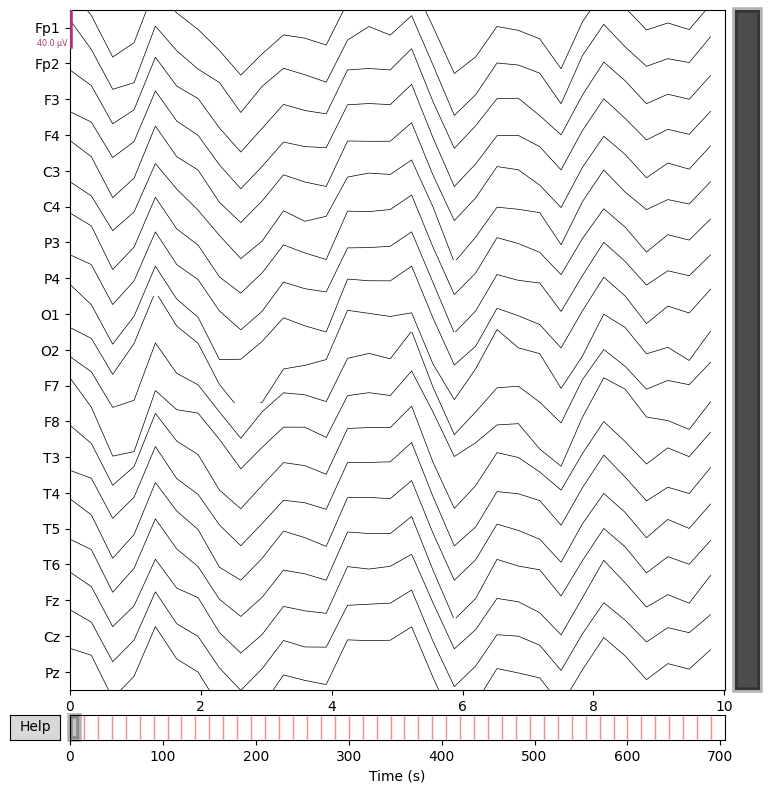

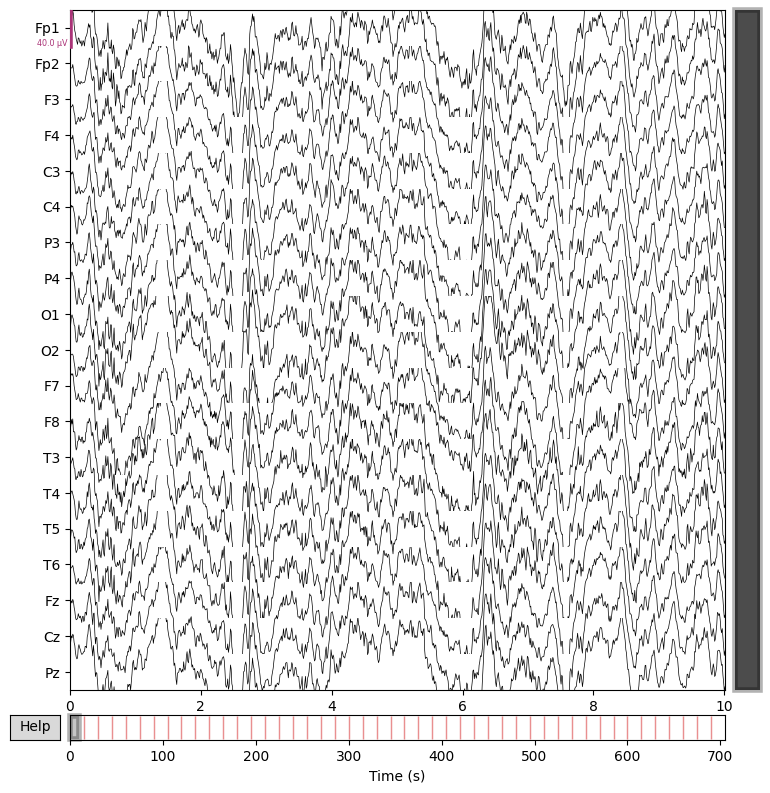

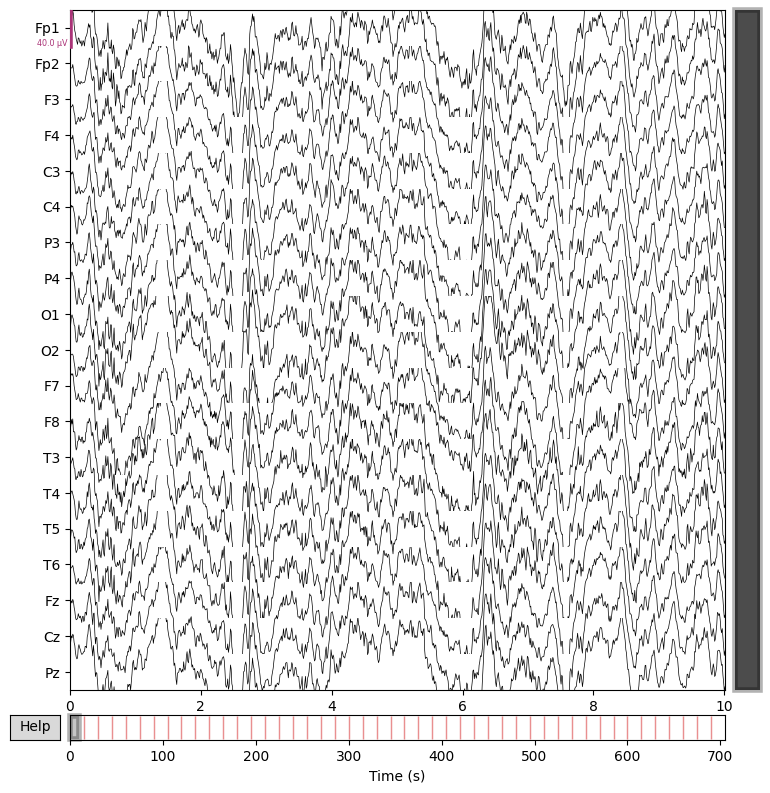

In [13]:
##Accessing cleaned raw
cleaned_raw = ica_by_subject["sub-060"]["cleaned_raw"]
cleaned_raw.plot()
raws_by_subject["sub-060"].plot()

In [14]:
##interpolation

def detect_bad_channels(raw, low_thresh=1e-7, high_thresh=1e-4):
    data = raw.get_data()
    stds = np.std(data, axis=1)

    bads = []
    for ch_name, std in zip(raw.ch_names, stds):
        if std < low_thresh or std > high_thresh:
            bads.append(ch_name)
    return bads

for subject_id, data in ica_by_subject.items():
    raw = data["cleaned_raw"]

    bads = detect_bad_channels(raw)
    raw.info['bads'] = bads
    # print(f"{subject_id}: Marked bad channels: {bads}")

    #Interpolate
    raw.interpolate_bads(reset_bads=True)

Setting channel interpolation method to {'eeg': 'spline'}.
Setting channel interpolation method to {'eeg': 'spline'}.
Setting channel interpolation method to {'eeg': 'spline'}.
Setting channel interpolation method to {'eeg': 'spline'}.
Setting channel interpolation method to {'eeg': 'spline'}.
Setting channel interpolation method to {'eeg': 'spline'}.
Setting channel interpolation method to {'eeg': 'spline'}.
Setting channel interpolation method to {'eeg': 'spline'}.
Setting channel interpolation method to {'eeg': 'spline'}.
Setting channel interpolation method to {'eeg': 'spline'}.
Setting channel interpolation method to {'eeg': 'spline'}.
Setting channel interpolation method to {'eeg': 'spline'}.
Setting channel interpolation method to {'eeg': 'spline'}.
Setting channel interpolation method to {'eeg': 'spline'}.
Setting channel interpolation method to {'eeg': 'spline'}.
Setting channel interpolation method to {'eeg': 'spline'}.
Setting channel interpolation method to {'eeg': 'spline'

In [ ]:
#refrencing (normalization)
for subject_id, data in ica_by_subject.items():
    raw = data["cleaned_raw"]
    raw.set_eeg_reference('average')


##Epoching

In [25]:
for subject_id, data in ica_by_subject.items():
    print(data["cleaned_raw"])

<RawEEGLAB | sub-036_eeg_chunk_0.set, 19 x 76950 (810.0 s), ~11.2 MiB, data loaded>
<RawEEGLAB | sub-018_eeg_chunk_0.set, 19 x 76950 (810.0 s), ~11.2 MiB, data loaded>
<RawEEGLAB | sub-055_eeg_chunk_0.set, 19 x 74100 (780.0 s), ~10.8 MiB, data loaded>
<RawEEGLAB | sub-008_eeg_chunk_0.set, 19 x 71250 (750.0 s), ~10.4 MiB, data loaded>
<RawEEGLAB | sub-045_eeg_chunk_0.set, 19 x 76950 (810.0 s), ~11.2 MiB, data loaded>
<RawEEGLAB | sub-026_eeg_chunk_0.set, 19 x 81225 (855.0 s), ~11.8 MiB, data loaded>
<RawEEGLAB | sub-029_eeg_chunk_0.set, 19 x 66975 (705.0 s), ~9.7 MiB, data loaded>
<RawEEGLAB | sub-017_eeg_chunk_0.set, 19 x 76950 (810.0 s), ~11.2 MiB, data loaded>
<RawEEGLAB | sub-074_eeg_chunk_0.set, 19 x 92625 (975.0 s), ~13.5 MiB, data loaded>
<RawEEGLAB | sub-058_eeg_chunk_0.set, 19 x 68400 (720.0 s), ~9.9 MiB, data loaded>
<RawEEGLAB | sub-007_eeg_chunk_0.set, 19 x 69825 (735.0 s), ~10.1 MiB, data loaded>
<RawEEGLAB | sub-039_eeg_chunk_0.set, 19 x 76950 (810.0 s), ~11.2 MiB, data lo

In [ ]:
# Parameters for epoching
epoch_duration = 2.0  # seconds
epoch_overlap = 1.0   # seconds
target_length = 256   # Target length (in time points)

# Loop through subjects and process the data
for subject_id, data in ica_by_subject.items():
    raw = data["cleaned_raw"]

    # Create fixed-length epochs with overlap
    epochs = mne.make_fixed_length_epochs(
        raw,
        duration=epoch_duration,
        overlap=epoch_overlap,
        preload=True
    )

    # Get the raw data of the epochs as a NumPy array
    epoch_data = epochs.get_data()  # Shape: (n_epochs, n_channels, n_times)

    # Pad or truncate epochs
    n_epochs, n_channels, n_times = epoch_data.shape

    # If any epoch is shorter than target_length, pad it
    if n_times < target_length:
        # Calculate the pad length
        pad_width = target_length - n_times
        # Pad the time axis of all epochs with zeros
        epoch_data = np.pad(epoch_data, ((0, 0), (0, 0), (0, pad_width)), mode='constant', constant_values=0)
    # If any epoch is longer than target_length, truncate it
    elif n_times > target_length:
        # Truncate the time axis of all epochs to target_length
        epoch_data = epoch_data[:, :, :target_length]

    # Create new epochs from the modified data
    epochs = mne.EpochsArray(epoch_data, raw.info)

    # Store the result in the data dictionary
    data["epochs"] = epochs
    print(f"{subject_id}: Created {len(epochs)} epochs, all of {target_length} time points.")


In [31]:
#sanity check
print(ica_by_subject["sub-001"]["epochs"].get_data().shape)


(532, 19, 190)


In [48]:
import json

label_file = "model-data/Labels.json"
output_path = "model-data/Labels_epochs.json"
# Read the JSON
with open(label_file, 'r') as f:
    label_entries = json.load(f)

# Build subject → label mapping
subject_labels = {}

for entry in label_entries:
    file_path = entry["file_name"]  # e.g., "train/sub-077_eeg_chunk_0.set"
    subject_id = file_path.split("/")[-1].split("_eeg_chunk_")[0]  # Extract "sub-077"
    label = entry["label"]

    # Only set it once (to avoid reassigning the same subject multiple times)
    if subject_id not in subject_labels:
        subject_labels[subject_id] = label

print(subject_labels)
with open(output_path, 'w') as file:
    json.dump(subject_labels, file, indent=4)



{'sub-077': 'F', 'sub-001': 'A', 'sub-027': 'A', 'sub-023': 'A', 'sub-013': 'A', 'sub-068': 'F', 'sub-011': 'A', 'sub-019': 'A', 'sub-005': 'A', 'sub-069': 'F', 'sub-086': 'F', 'sub-066': 'F', 'sub-054': 'C', 'sub-081': 'F', 'sub-085': 'F', 'sub-065': 'C', 'sub-034': 'A', 'sub-080': 'F', 'sub-056': 'C', 'sub-074': 'F', 'sub-012': 'A', 'sub-031': 'A', 'sub-041': 'C', 'sub-029': 'A', 'sub-010': 'A', 'sub-067': 'F', 'sub-006': 'A', 'sub-040': 'C', 'sub-032': 'A', 'sub-036': 'A', 'sub-046': 'C', 'sub-045': 'C', 'sub-017': 'A', 'sub-043': 'C', 'sub-035': 'A', 'sub-008': 'A', 'sub-050': 'C', 'sub-062': 'C', 'sub-020': 'A', 'sub-073': 'F', 'sub-026': 'A', 'sub-048': 'C', 'sub-014': 'A', 'sub-025': 'A', 'sub-004': 'A', 'sub-018': 'A', 'sub-039': 'C', 'sub-009': 'A', 'sub-070': 'F', 'sub-007': 'A', 'sub-057': 'C', 'sub-037': 'C', 'sub-079': 'F', 'sub-088': 'F', 'sub-055': 'C', 'sub-044': 'C', 'sub-051': 'C', 'sub-047': 'C', 'sub-087': 'F', 'sub-016': 'A', 'sub-071': 'F', 'sub-028': 'A', 'sub-04

In [50]:
import os
import numpy as np

output_dir = "epochs-numpy"
os.makedirs(output_dir, exist_ok=True)

for subject_id, data in ica_by_subject.items():
    epochs = data["epochs"]

    # Get the data as a NumPy array
    X = epochs.get_data()  # shape: (n_epochs, n_channels, n_times)

    # Save
    npy_path = os.path.join(output_dir, f"{subject_id}_epochs.npy")
    np.save(npy_path, X)



##Data Augmentation

In [51]:
def add_noise(X, std=0.01):
    return X + np.random.normal(0, std, X.shape)

def time_shift(X, max_shift=10):
    return np.array([np.roll(epoch, np.random.randint(-max_shift, max_shift), axis=1) for epoch in X])

def amplitude_scale(X, scale_range=(0.9, 1.1)):
    return np.array([epoch * np.random.uniform(*scale_range) for epoch in X])

In [34]:
for subject_id, data in ica_by_subject.items():
    epochs = data["epochs"]

    # Get the data as a NumPy array
    X = epochs.get_data()  # shape: (n_epochs, n_channels, n_times)

    # Apply augmentations
    X_noise = add_noise(X)
    X_shift = time_shift(X)
    X_scale = amplitude_scale(X)

    # Save augmented data (same labels)
    np.save(os.path.join(output_dir, f"{subject_id}_X_noise.npy"), X_noise)
    np.save(os.path.join(output_dir, f"{subject_id}_X_shift.npy"), X_shift)
    np.save(os.path.join(output_dir, f"{subject_id}_X_scale.npy"), X_scale)

    # print(f"Augmented {subject_id}: noise {X_noise.shape}, shift {X_shift.shape}, scale {X_scale.shape}")


In [53]:
from collections import Counter

epochs_dir = "epochs-numpy"
subject_ids = [f.split("_X.npy")[0] for f in os.listdir(epochs_dir) if f.endswith("_X.npy")]

# Step 3: Collect labels for train and test sets
train_labels = [subject_labels[sid] for sid in subject_ids if subject_split.get(sid) == "train"]
test_labels = [subject_labels[sid] for sid in subject_ids if subject_split.get(sid) == "test"]

# Step 4: Count labels
train_counts = Counter(train_labels)
test_counts = Counter(test_labels)

# Print results
print("Train label counts:", dict(train_counts))
print("Test label counts:", dict(test_counts))








Train label counts: {}
Test label counts: {}


88 npy files --> non data augmented
3*88 files --> augmented data

(532,19,90)


532 --> epochs


19 --> channels


90 --> num of points (3 seconds)

In [56]:
import random
import shutil

# Source and target directories
source_dir = "epochs-numpy"
train_dir = os.path.join(source_dir, "train")
test_dir = os.path.join(source_dir, "test")

# Make train/test directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# List all .npy files (excluding already split folders)
all_files = [f for f in os.listdir(source_dir) if f.endswith(".npy") and not f.startswith(("train", "test"))]

# Shuffle and split
random.seed(42)
random.shuffle(all_files)
split_idx = int(len(all_files) * 0.7)

train_files = all_files[:split_idx]
test_files = all_files[split_idx:]

# Copy files
for f in train_files:
    shutil.copy2(os.path.join(source_dir, f), os.path.join(train_dir, f))
for f in test_files:
    shutil.copy2(os.path.join(source_dir, f), os.path.join(test_dir, f))

# Optional: report
print(f"Train: {len(train_files)} files")
print(f"Test: {len(test_files)} files")


Train: 246 files
Test: 106 files


In [59]:

def count_labels_in_split(folder_path):
    label_counts = Counter()
    total_files = 0

    for filename in os.listdir(folder_path):
        if not filename.endswith(".npy"):
            continue

        subject_id = filename.split("_X")[0]
        label = subject_labels.get(subject_id)

        if label:
            label_counts[label] += 1
            total_files += 1

    return label_counts, total_files

# Get label counts
train_counts, train_total = count_labels_in_split("epochs-numpy/train")
test_counts, test_total = count_labels_in_split("epochs-numpy/test")

# Convert to percentages
train_percent = {label: f"{(count/train_total)*100:.2f}%" for label, count in train_counts.items()}
test_percent = {label: f"{(count/test_total)*100:.2f}%" for label, count in test_counts.items()}

# Show report
print("Train Label Distribution (%):", train_percent)
print("Test Label Distribution (%):", test_percent)

Train Label Distribution (%): {'F': '27.53%', 'C': '30.90%', 'A': '41.57%'}
Test Label Distribution (%): {'A': '39.53%', 'F': '23.26%', 'C': '37.21%'}


In [65]:
#Delete files not in test and train 

for f in os.listdir(source_dir):
    if f.endswith(".npy") and not f.startswith(("train", "test")):
        os.remove(os.path.join(source_dir, f)) 
